# Homework 1
In this homework, we will have you train some convolutional neural networks! We will start with a small dataset (CIFAR), and then work our way up to TinyImageNet! This homework originally written by Daniel Gordon with very minor modifications.

# Initial Setup

This will authenticate Colab to connect to your google drive account. This way you have space to store the datasets and won't have to redownload them every time. You'll also have stable storage to save your best performing networks.

In [ ]:
from google.colab import drive
drive.mount('/gdrive/')
!ls /gdrive

Mounted at /gdrive/
MyDrive  Shareddrives


Run this code to navigate to the BASE_PATH directory and upload the homework2.tar file inside the BASE_PATH, then extract it.

Have a look at [pt_util](https://gist.github.com/pjreddie/e531394d779af2da9201096af0dba78a). We moved some of the useful functions out of the python notebook to make it less cluttered, and added a few more useful functions.

I made the BASE_PATH and DATA_PATH variables so you don't have to copy the same strings all over the place if you want to move the locations of the files around.

In [1]:
import os

BASE_PATH = '/gdrive/My Drive/colab_files/hw1/'
if not os.path.exists(BASE_PATH):
    os.makedirs(BASE_PATH)
DATA_PATH = BASE_PATH + 'tiny_imagenet/'

!pwd
!ls
os.chdir(BASE_PATH)
if not os.path.exists(DATA_PATH + 'train.h5'):
    !wget https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework2.tar
    !tar -xvf homework2.tar
    !rm homework2.tar
!pwd
!ls
os.chdir('/content')

/content
sample_data
--2022-11-19 05:28:11--  https://courses.cs.washington.edu/courses/cse599g1/19au/files/homework2.tar
Resolving courses.cs.washington.edu (courses.cs.washington.edu)... 128.208.1.193, 2607:4000:200:10::c1
Connecting to courses.cs.washington.edu (courses.cs.washington.edu)|128.208.1.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1327554560 (1.2G) [application/x-tar]
Saving to: ‘homework2.tar’

homework2.tar       100%[===================>]   1.24G  44.3MB/s    in 28s     

2022-11-19 05:28:39 (45.4 MB/s) - ‘homework2.tar’ saved [1327554560/1327554560]

pt_util.py
tiny_imagenet/
tiny_imagenet/train.h5
tiny_imagenet/class_names.txt
tiny_imagenet/val.h5
/gdrive/My Drive/colab_files/hw1
pt_util.py  tiny_imagenet


# CIFAR

## Part 1: Getting the Dataset
Normally, we'd want to download our dataset first. Since PyTorch hosts the CIFAR dataset, we can load it using their helper function later.

But, we'll change DATA_PATH to an empty directory to download the dataset to.

In [ ]:
DATA_PATH = BASE_PATH + 'cifar/'

## Part 2: Defining the Network
Just like with MNIST last homework we need to define our network architecture. This time we will be using convolutional layers and maxpooling to extract features from our images before we feed those features into our final classifier.

Check out the documentation for [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html):

    nn.Conv2d(in_channels, out_channels, kernel_size, stride = 1, padding = 0,...)

So the first parameter is the number of channels in the input. Second is the number of filters we'll use (AKA number of channels in the output). Third is kernel size. Next is stride and padding which are optional and have default values.

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import h5py
import sys
sys.path.append(BASE_PATH)
import pt_util

In [ ]:
class CifarNet(nn.Module):
    def __init__(self):
        super(CifarNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(512, 512, 3, stride=1, padding=1)

        self.bnorm1 = nn.BatchNorm2d(64)
        self.bnorm2 = nn.BatchNorm2d(128)
        self.bnorm3 = nn.BatchNorm2d(256)
        self.bnorm4 = nn.BatchNorm2d(512)
        self.fc1 = nn.Linear(512 * 4, 10)
        self.maxp = nn.MaxPool2d((2, 2))
        self.accuracy = None

    def forward(self, x):
        x = self.conv1(x)
        # x = self.bnorm1(x)
        x = F.relu(x)

        x = self.maxp(x)

        x = self.conv2(x)
        # x = self.bnorm2(x)
        x = F.relu(x)

        x = self.maxp(x)

        x = self.conv3(x)
        # x = self.bnorm3(x)
        x = F.relu(x)

        x = self.conv4(x)
        # x = self.bnorm3(x)
        x = F.relu(x)

        x = self.maxp(x)

        x = self.conv5(x)
        # x = self.bnorm4(x)
        x = F.relu(x)

        # x = self.conv6(x)
        # x = self.bnorm4(x)
        # x = F.relu(x)

        # x = self.maxp(x)

        # x = self.conv6(x)
        # x = self.bnorm4(x)
        # x = F.relu(x)

        # x = self.conv6(x)
        # x = self.bnorm4(x)
        # x = F.relu(x)

        x = self.maxp(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


NameError: ignored

This time we are giving you the train and test functions, but feel free to modify them if you want. 

You may need to return some additional information for the logging portion of this assignment.


In [ ]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    return test_loss, test_accuracy

## Part 3 and 4: Loading Data and Dataset Augmentation

In the MNIST assignment, we didn't do any data augmentation because MNIST is kind of easy.

In this assignment, you may find that data augmentation helps you a lot (or possibly hurts your performance).

You can find a bunch preimplemented here https://pytorch.org/vision/stable/transforms.html and you can also do your own as seen in the tutorial from part 3.

Play around with various data augmentations we will suggest some.

- ToPILImage - This one is useful for a lot of the built in transforms which expect PIL images. 
- RandomHorizontalFlip
- RandomResizedCrop
- ColorJitter
- RandomRotation
- Normalize
- Adding various types of noise
- ToTensor - PyTorch expects the output from the dataset to be a tensor in CxHxW format.


Note: You should be careful about which of these you apply to the test data. You usually don't want to apply noise to the test data, but you do want to normalize it in the same way for example.

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(180),
    # transforms.ColorJitter(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

data_train = datasets.CIFAR10(root=DATA_PATH, train=True, download=True, transform=transform_train)
data_test = datasets.CIFAR10(root=DATA_PATH, train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


## Part 5: Training the network
Generally, it is useful to see how your training is going. Often people print their loss to make sure it goes down and their accuracy to make sure it goes up. But pictures are better than words. So for this part, you should record and plot the training loss, test loss, and test accuracy (and whatever else you want). 

We have created a very simple logging interface which essentially just saves and restores files via pickle in pt_util. Saving and restoring log data is important if you end your run early and want to continue where you left off rather than starting over.

We have also provided a plot function which can plot a single line graph. You can use it and plot each value independently, or change it to plot them all in one graph. 

Try different network architectures and experiment with hyperparameters. You'll answer the questions at the bottom of the file based on these experiments.


__Important note: Do not forget to title your graphs and label your axes. Plots are meaningless without a way to read them.__

Second Note: It will be helpful for you when deciding what network structure, data augmentation, and such work to title the graphs accordingly so you remember.

Third Note: The default setup right now saves and restores the network weights from a single folder. When you modify network architectures, you may want to increment your experiment version number so you start over with your training and log files.

Using device cuda
num cpus: 2
Restoring:
conv1.weight -> 	torch.Size([64, 3, 3, 3]) = 0MB
conv1.bias -> 	torch.Size([64]) = 0MB
conv2.weight -> 	torch.Size([128, 64, 3, 3]) = 0MB
conv2.bias -> 	torch.Size([128]) = 0MB
conv3.weight -> 	torch.Size([256, 128, 3, 3]) = 1MB
conv3.bias -> 	torch.Size([256]) = 0MB
conv4.weight -> 	torch.Size([256, 256, 3, 3]) = 2MB
conv4.bias -> 	torch.Size([256]) = 0MB
conv5.weight -> 	torch.Size([512, 256, 3, 3]) = 4MB
conv5.bias -> 	torch.Size([512]) = 0MB
conv6.weight -> 	torch.Size([512, 512, 3, 3]) = 9MB
conv6.bias -> 	torch.Size([512]) = 0MB
bnorm1.weight -> 	torch.Size([64]) = 0MB
bnorm1.bias -> 	torch.Size([64]) = 0MB
bnorm1.running_mean -> 	torch.Size([64]) = 0MB
bnorm1.running_var -> 	torch.Size([64]) = 0MB
bnorm1.num_batches_tracked -> 	torch.Size([]) = 0MB
bnorm2.weight -> 	torch.Size([128]) = 0MB
bnorm2.bias -> 	torch.Size([128]) = 0MB
bnorm2.running_mean -> 	torch.Size([128]) = 0MB
bnorm2.running_var -> 	torch.Size([128]) = 0MB
bnorm2.num_batch

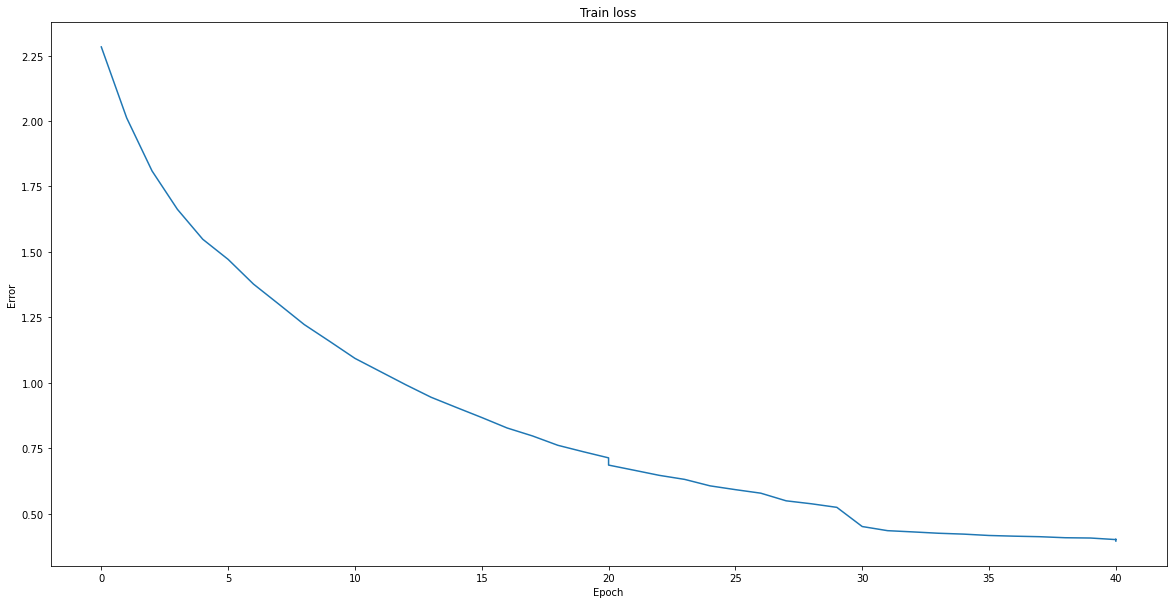

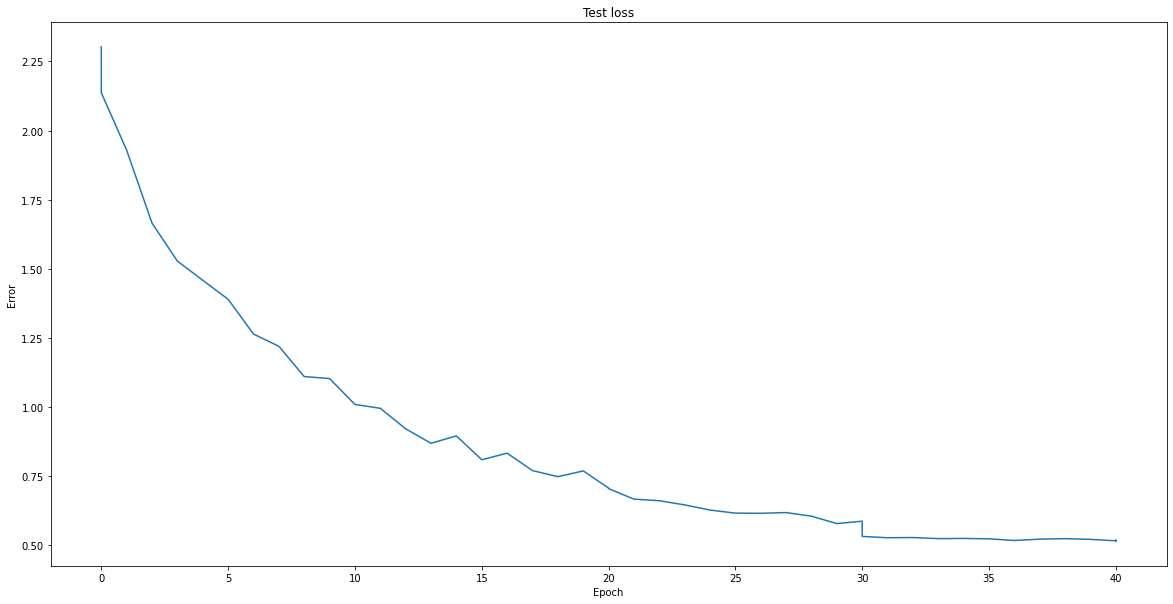

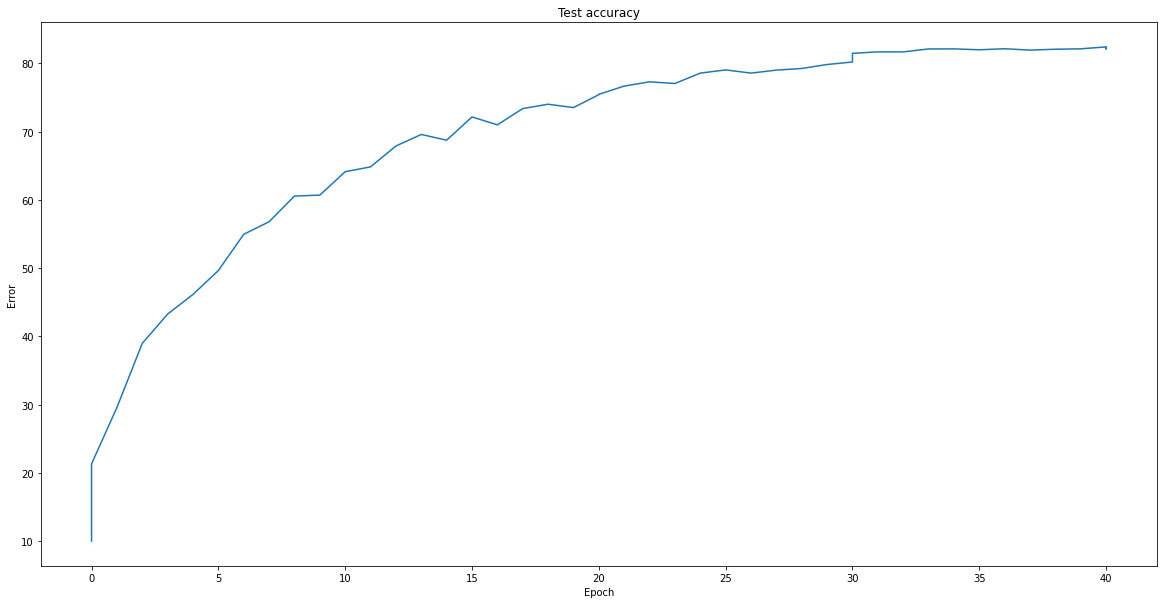

In [ ]:
# Play around with these constants, you may find a better setting.
BATCH_SIZE = 256
TEST_BATCH_SIZE = 10
EPOCHS = 40
LEARNING_RATE = 0.001
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005

EXPERIMENT_VERSION = "0.7" # increment this to start a new experiment
LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

#torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = CifarNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(LOG_PATH)

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
test_loss, test_accuracy = test(model, device, test_loader)

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH + 'log.pkl', (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')


##CIFAR Questions

1. What design that you tried worked the best? This includes things like network design, learning rate, batch size, number of epochs, and other optimization parameters, data augmentation etc. What was the final train loss? Test loss? Test Accuracy? Provide the plots for train loss, test loss, and test accuracy.

#### Network Design
```
self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
self.conv4 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
self.conv5 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
self.fc1 = nn.Linear(512 * 4, 10)
with RELU and MaxPool after each convolution
```
#### Parameters
```
BATCH_SIZE = 256
TEST_BATCH_SIZE = 10
EPOCHS = 40
LEARNING_RATE = 0.01 (30 epochs), 0.001 (10 epochs)
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005
```

#### Augmentation
```
transforms.RandomCrop(32, padding=4),
transforms.RandomHorizontalFlip(),
transforms.ToTensor(),
```

#### Result
```
Training Loss: 0.452538
Test loss: 0.5170
Accuracy: 8232/10000 (82%)
```

#### Visualization

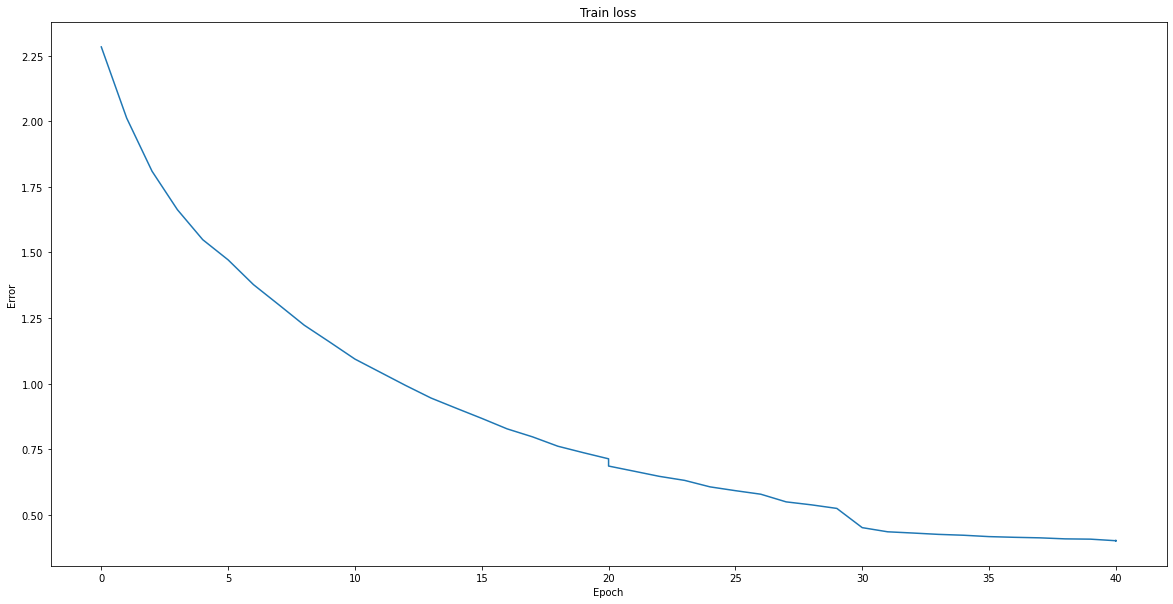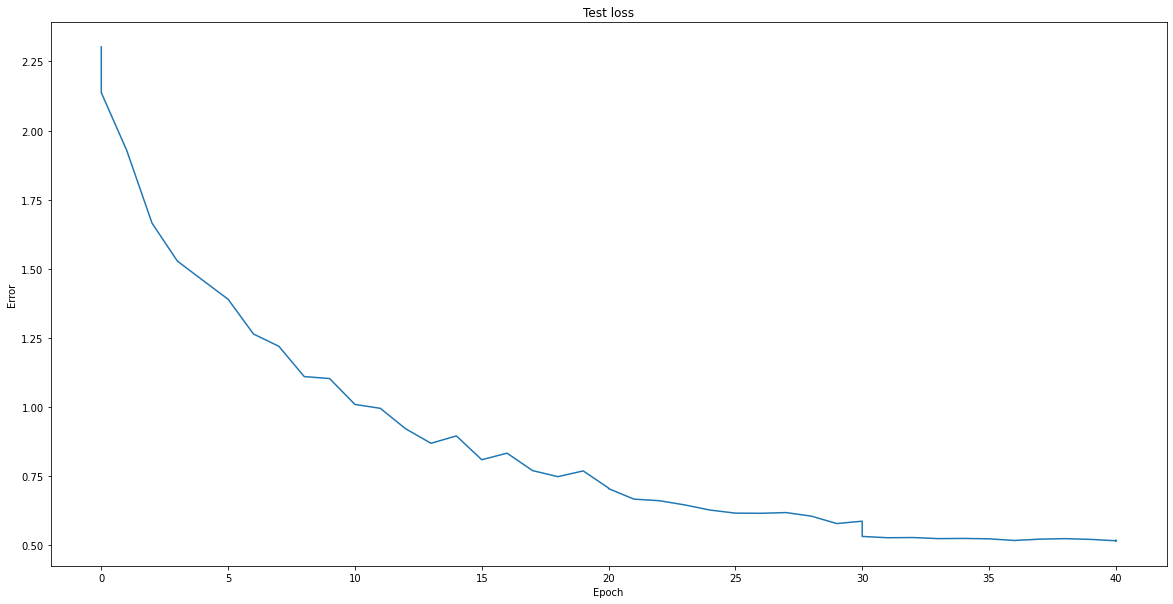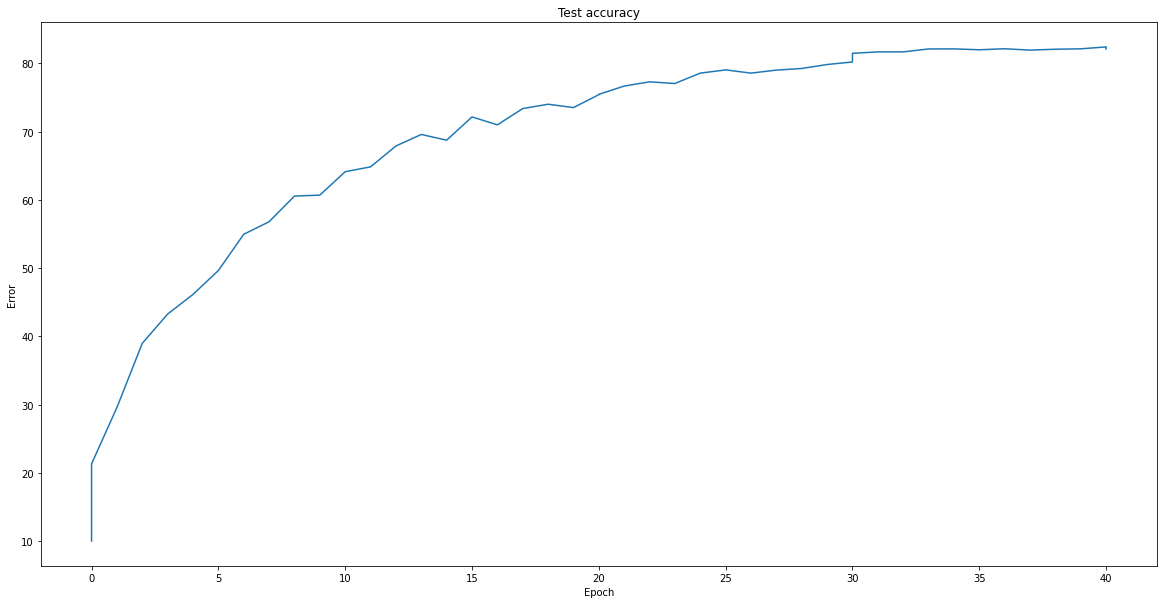

2. What design worked the worst (but still performed better than random chance)? Provide all the same information as question 1.

#### Network Design
```
self.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1)
self.conv2 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
self.conv3 = nn.Conv2d(128, 256, 3, stride=1, padding=1)
self.conv4 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
self.conv5 = nn.Conv2d(256, 512, 3, stride=1, padding=1)
self.conv6 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
self.fc1 = nn.Linear(512 * 4, 10)
with Batch Normalization, RELU and MaxPool after each convolution
```

#### Parameters
```
BATCH_SIZE = 256
TEST_BATCH_SIZE = 10
EPOCHS = 20
LEARNING_RATE = 0.01
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005
```

#### Augmentation
```
transforms.RandomRotation(180),
transforms.ColorJitter(),
transforms.ToTensor()
```
#### Result
```
Train Loss: 0.744435
Test loss: 3.7208
Accuracy: 2094/10000 (21%)
```

#### Visualization

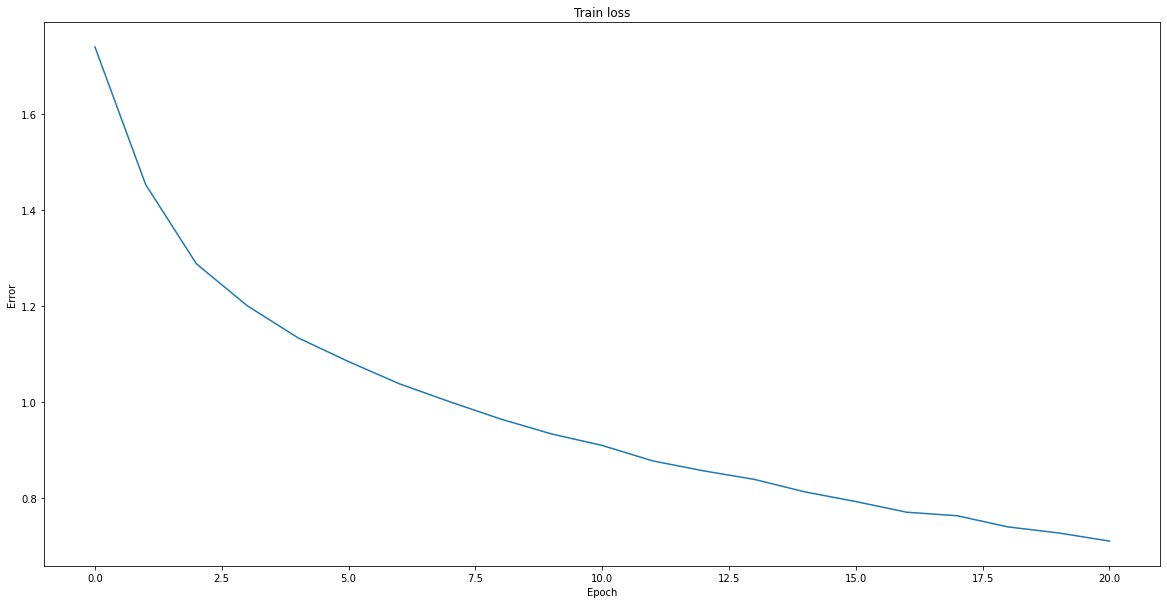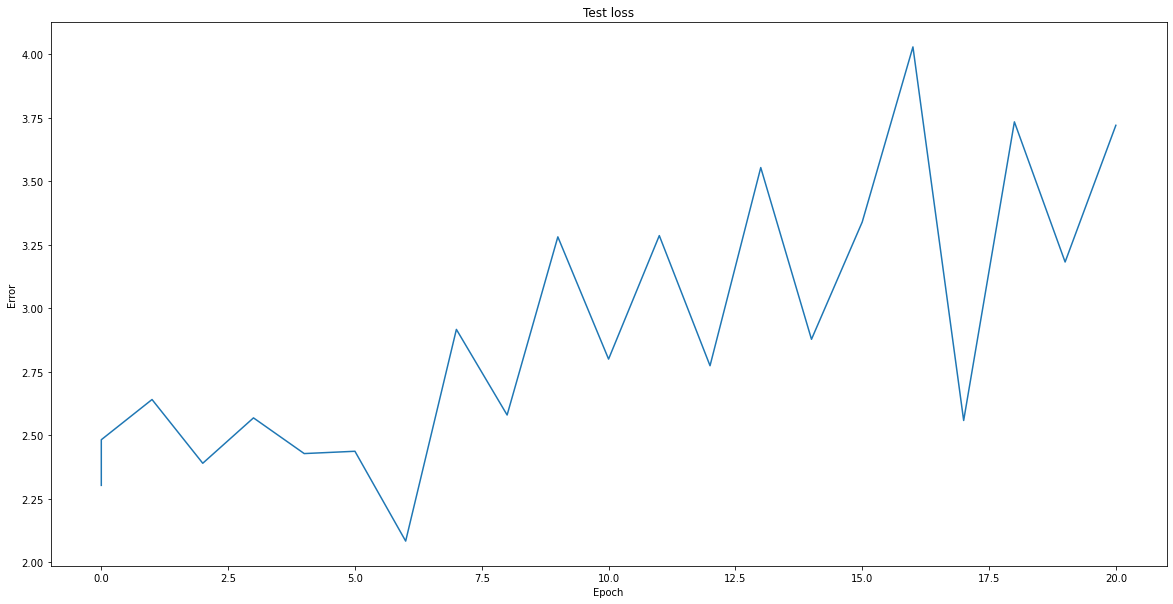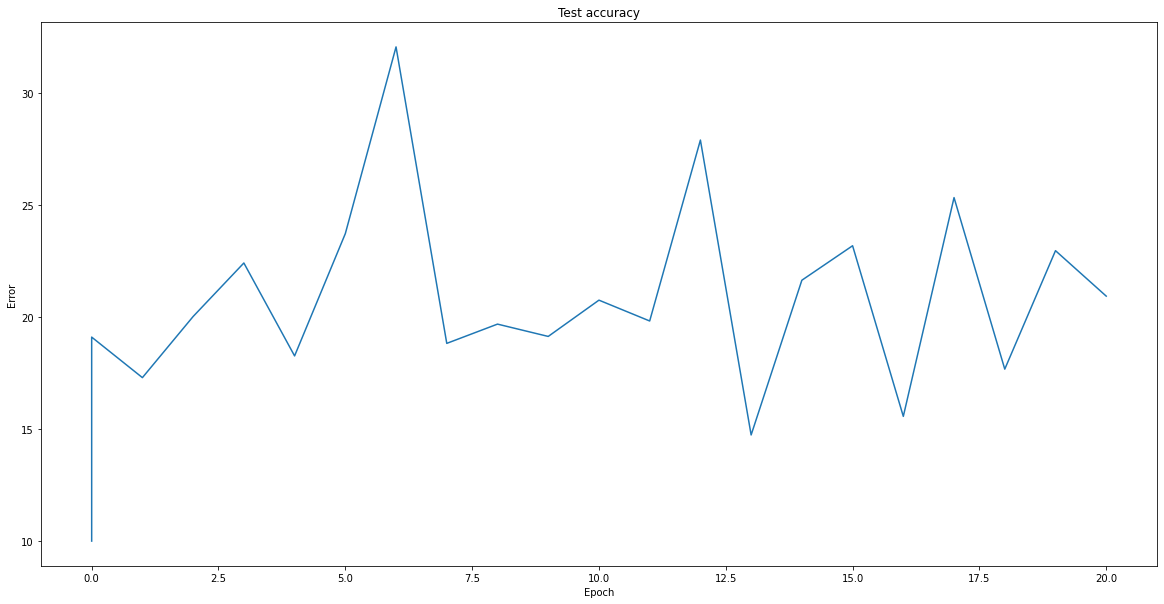

3. Why do you think the best one worked well and the worst one worked poorly.

The best one works well as it uses max pooling with stride = 2 to reduce the input size. It is also big enough to ensure that the model has enough weights to classify the image accurately. I use most of the default parameters as they are all decent choices (except the learning rate is reduced to 0.001 after 30 epochs). The default data augmentation also works well (much better than nothing) and all other augmentation that I try only perform worse or similarly. 0.7

The worst one worked poorly as the data augmentation used seems to distort the image too much that the model fails to learn it well. The batch normalization might also poses too much regularization so that the model fails to converge to a minimum value. Even though I experiment with more epochs, the model also fails to converge.

---
# TinyImageNet

## Part 1: Upload the Dataset
Change the DATA_PATH to the path of the TinyImageNet dataset we downloaded earlier.

In [2]:
DATA_PATH = BASE_PATH + 'tiny_imagenet/'

## Part 2: Defining the Network
We're giving you no instructions on this part. Welcome to deep learning research! See if you can get above 40% accuracy. You probably want to use the Cross Entropy error again, but who knows, maybe you can find a better loss function. We will give you a few hints of things to try:

- Maxpooling
- Activation functions other than ReLU
- Batch Norm
- Dropout
- Residual connections

To define your network you'll have to figure out more about the Tiny ImageNet dataset. Specifically, what size are the images you'll be processing? How big is your label space? You can find this out by examining samples of your data.

In [3]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import numpy as np
import os
import torch.nn.functional as F
import torch.optim as optim
import h5py
import sys
sys.path.append(BASE_PATH)
import pt_util

In [36]:
class TinyImagenetNet(nn.Module):
    def __init__(self):
        super(TinyImagenetNet, self).__init__()

        self.layer0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64)
        )

        self.res1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, stride=2),
            nn.BatchNorm2d(128)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, stride=2),
            nn.BatchNorm2d(128)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
        )

        self.res2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1, stride=2),
            nn.BatchNorm2d(256)
        )

        self.layer6 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=1, stride=2),
            nn.BatchNorm2d(256)
        )

        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
        )

        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.BatchNorm2d(256),
        )

        self.res3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=1, stride=2),
            nn.BatchNorm2d(512)
        )

        self.layer9 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=1, stride=2),
            nn.BatchNorm2d(512)
        )

        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
        )

        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, stride=1, padding=1),
            nn.BatchNorm2d(512),
        )

        self.fc1 = nn.Linear(512, 200, bias = True)
        self.maxp = nn.MaxPool2d(3, 2)
        self.avgp = nn.AdaptiveAvgPool2d(output_size = (1, 1))
        self.dropout = nn.Dropout(0.25)
        self.accuracy = None

    def forward(self, x):
        # 3 64
        x = self.layer0(x)

        # 64 64
        temp = x
        x = self.layer1(x)
        x += temp

        # 64 64
        temp = x
        x = self.layer2(x)
        x += temp

        # 64 128
        temp = self.res1(x)
        x = self.layer3(x)

        # 128 128
        x = self.layer4(x)
        x += temp

        temp = x
        x = self.layer5(x)
        x += temp

        # 128 256
        temp = self.res2(temp)
        x = self.layer6(x)

        # 256 256
        x = self.layer7(x)
        x += temp

        temp = x
        x = self.layer8(x)
        x += temp

        # 256 512
        temp = self.res3(temp)
        x = self.layer9(x)

        # 512 512
        x = self.layer10(x)
        x += temp

        temp = x
        x = self.layer11(x)
        x += temp

        x = self.avgp(x)

        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

    def loss(self, prediction, label, reduction='mean'):
        loss_val = F.cross_entropy(prediction, label.squeeze(), reduction=reduction)
        return loss_val

    def save_model(self, file_path, num_to_keep=1):
        pt_util.save(self, file_path, num_to_keep)
        
    def save_best_model(self, accuracy, file_path, num_to_keep=1):
        if self.accuracy == None or accuracy > self.accuracy:
            self.accuracy = accuracy
            self.save_model(file_path, num_to_keep)

    def load_model(self, file_path):
        pt_util.restore(self, file_path)

    def load_last_model(self, dir_path):
        return pt_util.restore_latest(self, dir_path)


In [46]:
from torchsummary import summary

model = TinyImagenetNet()
model.to(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,472
         MaxPool2d-2           [-1, 64, 16, 16]               0
       BatchNorm2d-3           [-1, 64, 16, 16]             128
              ReLU-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,928
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,928
       BatchNorm2d-9           [-1, 64, 16, 16]             128
           Conv2d-10           [-1, 64, 16, 16]          36,928
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          36,928
      BatchNorm2d-14           [-1, 64,

This time we are giving you the train and test functions, but feel free to modify them if you want. 

You may need to return some additional information for the logging portion of this assignment.


In [7]:
import time
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    losses = []
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(device), label.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = model.loss(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('{} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                time.ctime(time.time()),
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(losses)

def test(model, device, test_loader, return_images=False, log_interval=None):
    model.eval()
    test_loss = 0
    correct = 0

    correct_images = []
    correct_values = []

    error_images = []
    predicted_values = []
    gt_values = []
    with torch.no_grad():
        for batch_idx, (data, label) in enumerate(test_loader):
            data, label = data.to(device), label.to(device)
            output = model(data)
            test_loss_on = model.loss(output, label, reduction='sum').item()
            test_loss += test_loss_on
            pred = output.max(1)[1]
            correct_mask = pred.eq(label.view_as(pred))
            num_correct = correct_mask.sum().item()
            correct += num_correct
            if return_images:
                if num_correct > 0:
                    correct_images.append(data[correct_mask, ...].data.cpu().numpy())
                    correct_value_data = label[correct_mask].data.cpu().numpy()[:, 0]
                    correct_values.append(correct_value_data)
                if num_correct < len(label):
                    error_data = data[~correct_mask, ...].data.cpu().numpy()
                    error_images.append(error_data)
                    predicted_value_data = pred[~correct_mask].data.cpu().numpy()
                    predicted_values.append(predicted_value_data)
                    gt_value_data = label[~correct_mask].data.cpu().numpy()[:, 0]
                    gt_values.append(gt_value_data)
            if log_interval is not None and batch_idx % log_interval == 0:
                print('{} Test: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    time.ctime(time.time()),
                    batch_idx * len(data), len(test_loader.dataset),
                    100. * batch_idx / len(test_loader), test_loss_on))
    if return_images:
        correct_images = np.concatenate(correct_images, axis=0)
        error_images = np.concatenate(error_images, axis=0)
        predicted_values = np.concatenate(predicted_values, axis=0)
        correct_values = np.concatenate(correct_values, axis=0)
        gt_values = np.concatenate(gt_values, axis=0)

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), test_accuracy))
    if return_images:
        return test_loss, test_accuracy, correct_images, correct_values, error_images, predicted_values, gt_values
    else:
        return test_loss, test_accuracy


## Part 3: Loading Data
PyTorch has a nice interface for dealing with a variety of data. You can read a good tutorial here https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
Your friendly neighborhood TAs have made it even easier by preprocessing the data into a nice format. The data you uploaded is stored using hdf5 files which can be accessed a lot like Numpy arrays using the h5py package. In each of the files, there is a "dataset" called 'images', and one called 'labels'. Read more about h5py here http://docs.h5py.org/en/latest/quick.html

Hints:
1. HDF5s don't support concurrent accesses.
2. If you don't close the HDF5 file, you will still have problems with concurrency.
3. One way to deal with concurrent accesses is to copy the entirety of the data into each process separately. Then each process accesses its own copy of the data. https://stackoverflow.com/questions/40449659/does-h5py-read-the-whole-file-into-memory
4. Speed hint: With small datasets, it is almost always a good idea to cache the data to disk rather than continually read from files.


In [8]:
# Data loader
class H5Dataset(torch.utils.data.Dataset):
    def __init__(self, h5_file, transform=None):
        self.transform = transform
        self.h5_file = h5py.File(h5_file, 'r')
        self.images = self.h5_file['images'][:]
        self.labels = torch.LongTensor(self.h5_file['labels'][:])
        
    def __len__(self):
        return self.labels.shape[0]
      
    def __getitem__(self, idx):
        data = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            data = self.transform(data)
        return (data, label)


## Part 4: Dataset Augmentation
In the MNIST assignment, we didn't do any data augmentation because MNIST is kind of easy.

In this assignment, you may find that data augmentation helps you a lot (or possibly hurts your performance).

You can find a bunch preimplemented here https://pytorch.org/docs/stable/torchvision/transforms.html and you can also do your own as seen in the tutorial from part 3.

Play around with various data augmentations we will suggest some.

- ToPILImage - This one is useful for a lot of the built in transforms which expect PIL images. 
- RandomHorizontalFlip
- RandomResizedCrop
- ColorJitter
- RandomRotation
- Normalize
- Adding various types of noise
- ToTensor - PyTorch expects the output from the dataset to be a tensor in CxHxW format.


Note: You should be careful about which of these you apply to the test data. You usually don't want to apply noise to the test data, but you do want to normalize it in the same way for example.


In [9]:
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(64, padding=3),
    transforms.ToTensor(),
    ])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    ])

data_train = H5Dataset(DATA_PATH + 'train.h5', transform=train_transforms)
print(len(data_train))
data_test = H5Dataset(DATA_PATH + 'val.h5', transform=test_transforms)
print(len(data_test))


100000
8000


## Part 5: Training the network
Generally, it is useful to see how your training is going. Often people print their loss to make sure it goes down and their accuracy to make sure it goes up. But pictures are better than words. So for this part, you should record and plot the training loss, test loss, and test accuracy (and whatever else you want). 

We have created a very simple logging interface which essentially just saves and restores files via pickle in pt_util. Saving and restoring log data is important if you end your run early and want to continue where you left off rather than starting over.

We have also provided a plot function which can plot a single line graph. You can use it and plot each value independently, or change it to plot them all in one graph. 


__Important note: Do not forget to title your graphs and label your axes. Plots are meaningless without a way to read them.__

Second Note: It will be helpful for you when deciding what network structure, data augmentation, and such work to title the graphs accordingly so you remember.
Third Note: The default setup right now saves and restores the network weights from a single folder. When you modify network architectures, you may want to save the resulting files in different folders (with appropriate names).

We also provided a function for showing some results, because it's not satisfying to train a neural net, you also want to see what it can do! This can also be useful for figuring out what your network is doing well, and what it is failing at. This type of error analysis is very common when training neural networks.


In [44]:
def l_rate(n):
    if n < 20:
        return 0.001
    elif n < 25:
        return 0.0001
    else:
        return 0.00001

Using device cuda
num cpus: 2

Test set: Average loss: 5.2996, Accuracy: 40/8000 (0%)



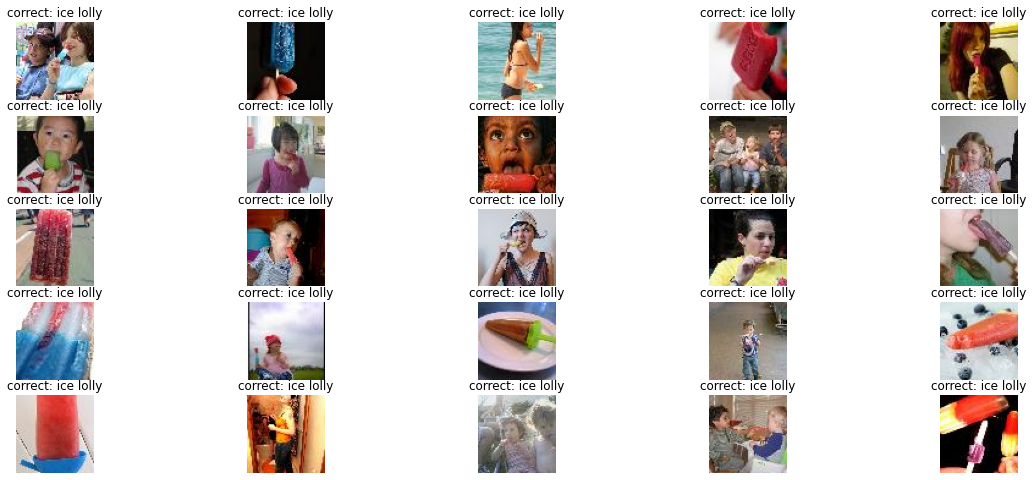

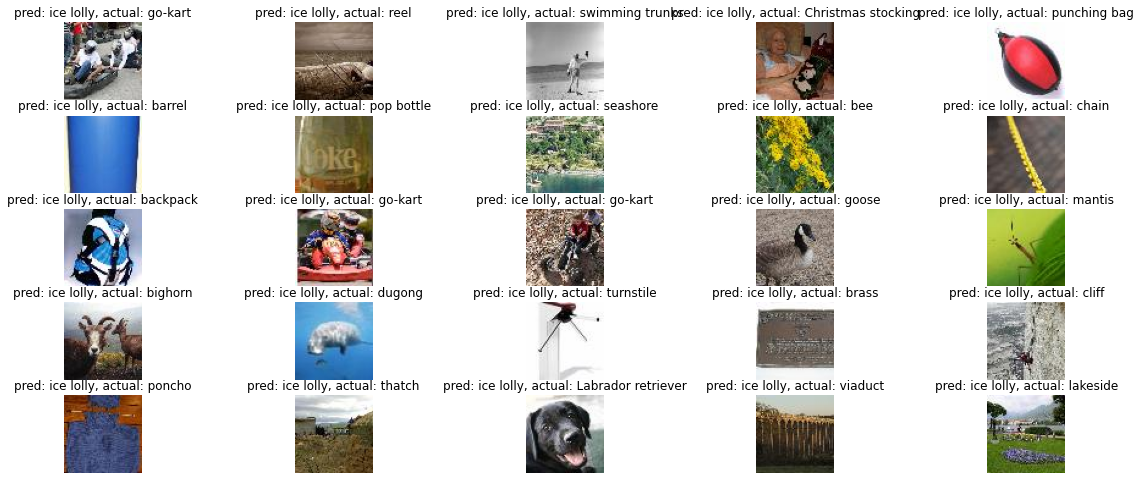

Sat Nov 19 07:36:45 2022 Train Epoch: 0 [0/100000 (0%)]	Loss: 5.474747
Sat Nov 19 07:36:54 2022 Train Epoch: 0 [25600/100000 (26%)]	Loss: 4.929358
Sat Nov 19 07:37:03 2022 Train Epoch: 0 [51200/100000 (51%)]	Loss: 4.570910
Sat Nov 19 07:37:12 2022 Train Epoch: 0 [76800/100000 (77%)]	Loss: 4.434912

Test set: Average loss: 4.2669, Accuracy: 954/8000 (12%)

Saved /gdrive/My Drive/colab_files/hw1/tiny_imagenet/logs/0.7/000.pt

Sat Nov 19 07:37:29 2022 Train Epoch: 1 [0/100000 (0%)]	Loss: 4.281369
Sat Nov 19 07:37:38 2022 Train Epoch: 1 [25600/100000 (26%)]	Loss: 4.050466
Sat Nov 19 07:37:48 2022 Train Epoch: 1 [51200/100000 (51%)]	Loss: 4.125416
Sat Nov 19 07:37:58 2022 Train Epoch: 1 [76800/100000 (77%)]	Loss: 3.910195

Test set: Average loss: 3.9331, Accuracy: 1289/8000 (16%)

Saved /gdrive/My Drive/colab_files/hw1/tiny_imagenet/logs/0.7/001.pt

Sat Nov 19 07:38:14 2022 Train Epoch: 2 [0/100000 (0%)]	Loss: 3.754259
Sat Nov 19 07:38:23 2022 Train Epoch: 2 [25600/100000 (26%)]	Loss: 3.842

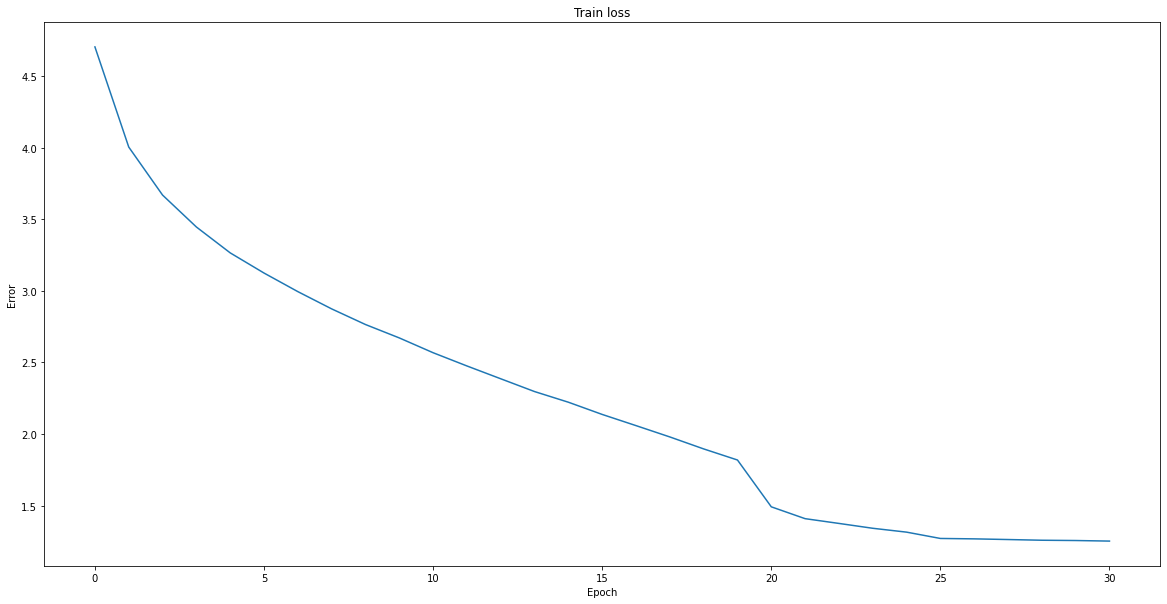

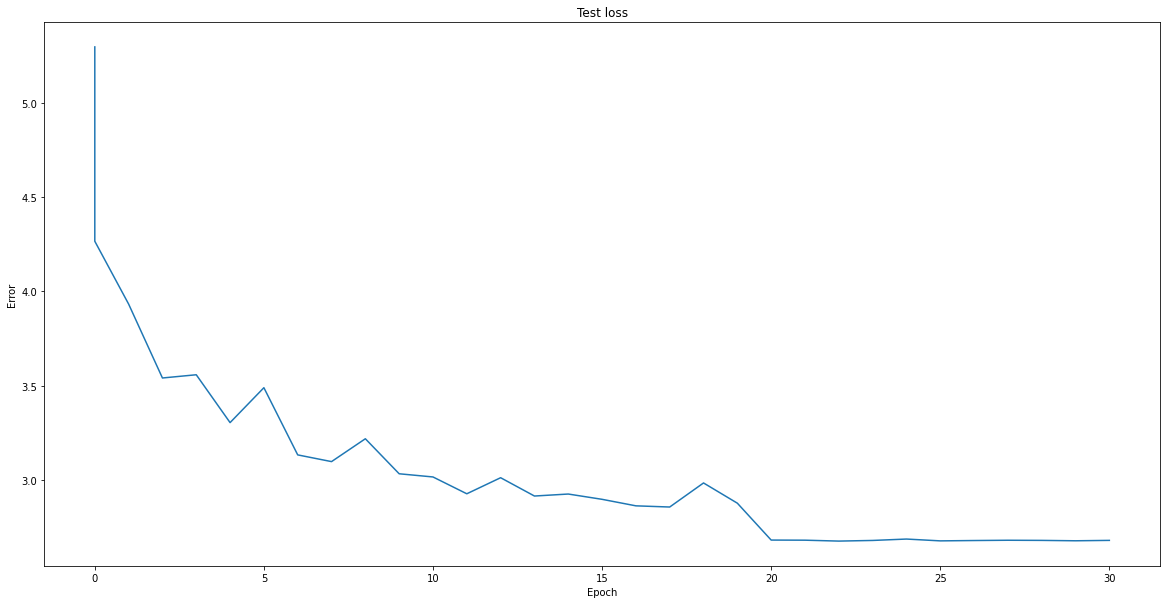

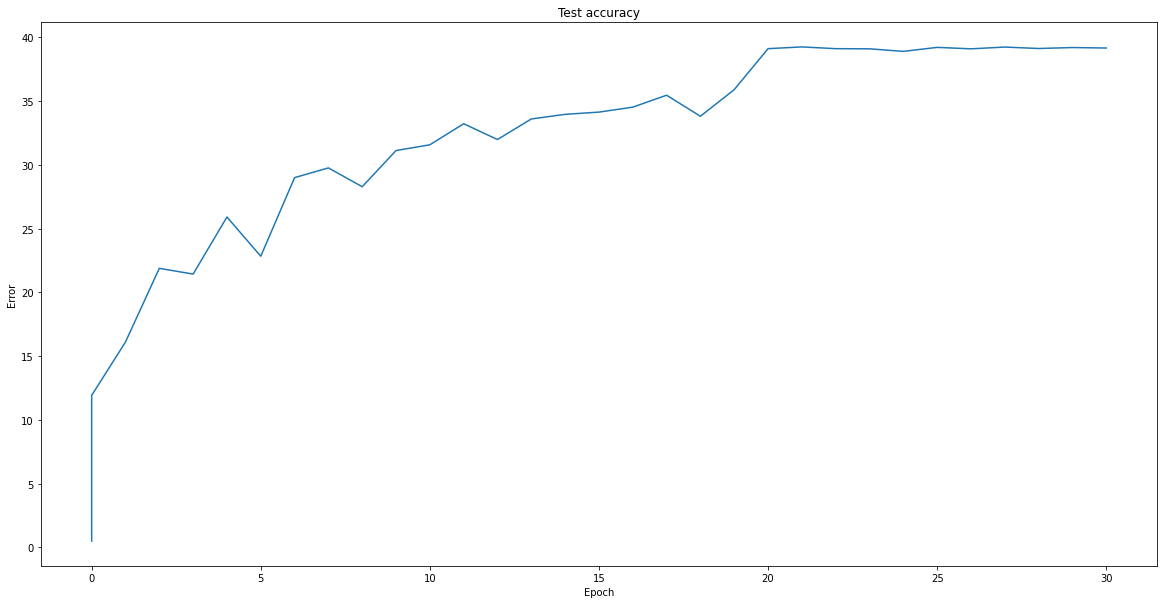

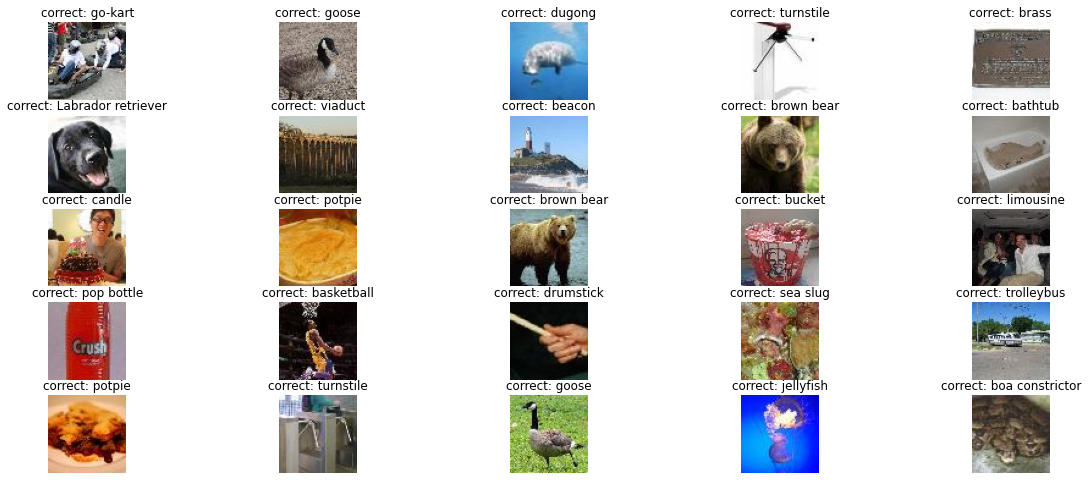

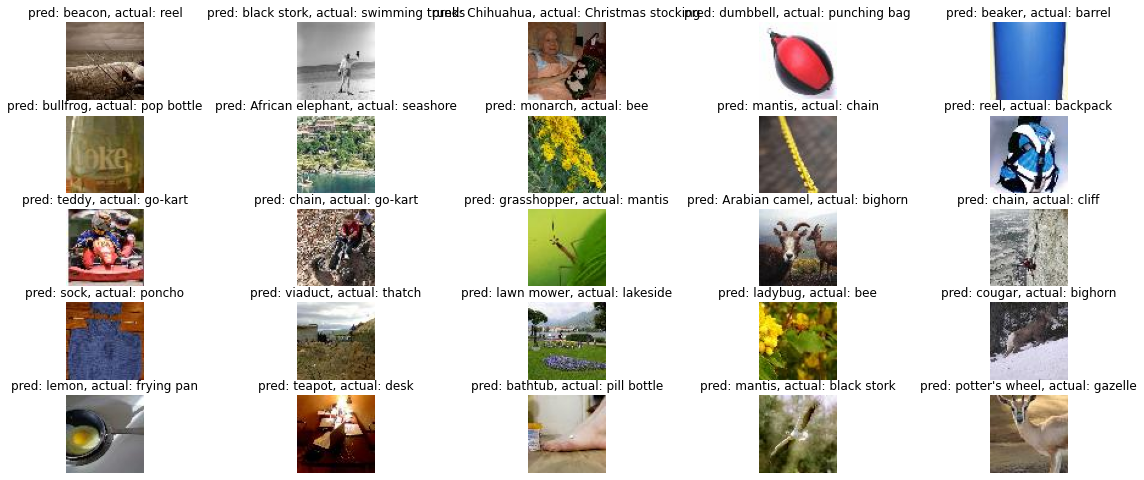

In [45]:
# Play around with these constants, you may find a better setting.
BATCH_SIZE = 256
TEST_BATCH_SIZE = 10
EPOCHS = 30
LEARNING_RATE = 0.001
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005

EXPERIMENT_VERSION = "0.7" # increment this to start a new experiment
LOG_PATH = DATA_PATH + 'logs/' + EXPERIMENT_VERSION + '/'

# Now the actual training code
use_cuda = USE_CUDA and torch.cuda.is_available()

#torch.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count())

kwargs = {'num_workers': multiprocessing.cpu_count(),
          'pin_memory': True} if use_cuda else {}

class_names = [line.strip().split(', ') for line in open(DATA_PATH + 'class_names.txt')]
name_to_class = {line[1]: line[0] for line in class_names}
class_names = [line[1] for line in class_names]

train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,
                                           shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=TEST_BATCH_SIZE,
                                          shuffle=False, **kwargs)

model = TinyImagenetNet().to(device)
# model = ResNet18(3, ResBlock, outputs = 200).to(device)
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
start_epoch = model.load_last_model(LOG_PATH)

train_losses, test_losses, test_accuracies = pt_util.read_log(LOG_PATH + 'log.pkl', ([], [], []))
test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)

correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])

test_losses.append((start_epoch, test_loss))
test_accuracies.append((start_epoch, test_accuracy))

try:
    for epoch in range(start_epoch, EPOCHS + 1):
        optimizer = optim.SGD(model.parameters(), lr=l_rate(epoch), momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        train_loss = train(model, device, train_loader, optimizer, epoch, PRINT_INTERVAL)
        test_loss, test_accuracy, correct_images, correct_val, error_images, predicted_val, gt_val = test(model, device, test_loader, True)
        train_losses.append((epoch, train_loss))
        test_losses.append((epoch, test_loss))
        test_accuracies.append((epoch, test_accuracy))
        pt_util.write_log(LOG_PATH + '.pkl', (train_losses, test_losses, test_accuracies))
        model.save_best_model(test_accuracy, LOG_PATH + '%03d.pt' % epoch)


except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    model.save_model(LOG_PATH + '%03d.pt' % epoch, 0)
    ep, val = zip(*train_losses)
    pt_util.plot(ep, val, 'Train loss', 'Epoch', 'Error')
    ep, val = zip(*test_losses)
    pt_util.plot(ep, val, 'Test loss', 'Epoch', 'Error')
    ep, val = zip(*test_accuracies)
    pt_util.plot(ep, val, 'Test accuracy', 'Epoch', 'Error')
    correct_images = pt_util.to_scaled_uint8(correct_images.transpose(0, 2, 3, 1))
    error_images = pt_util.to_scaled_uint8(error_images.transpose(0, 2, 3, 1))
    pt_util.show_images(correct_images, ['correct: %s' % class_names[aa] for aa in correct_val])
    pt_util.show_images(error_images, ['pred: %s, actual: %s' % (class_names[aa], class_names[bb]) for aa, bb in zip(predicted_val, gt_val)])


## TinyImageNet Questions

1. What design that you tried worked the best? How many epochs were you able to run it for? Provide the same information from CIFAR question 1.

#### Network Design
The network design is specified in `TinyImagenetNet` class. Basically, it follows the wisdom of ResNet 11. It consists of convolution from `3 -> 64 -> 128 -> 256 -> 512` (with residual connection and batch normalization). In the first layer, there is a max pooling. After the last convolution layer, there is a avg pooling, followed with `dropout(0.25)` and ended with a fully connected layer `(512 -> 200)`.

The following is the model summary produced by `torchsummary`
```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1           [-1, 64, 32, 32]           9,472
         MaxPool2d-2           [-1, 64, 16, 16]               0
       BatchNorm2d-3           [-1, 64, 16, 16]             128
              ReLU-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,928
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          36,928
       BatchNorm2d-9           [-1, 64, 16, 16]             128
           Conv2d-10           [-1, 64, 16, 16]          36,928
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
           Conv2d-13           [-1, 64, 16, 16]          36,928
      BatchNorm2d-14           [-1, 64, 16, 16]             128
           Conv2d-15            [-1, 128, 8, 8]           8,320
      BatchNorm2d-16            [-1, 128, 8, 8]             256
           Conv2d-17            [-1, 128, 8, 8]           8,320
      BatchNorm2d-18            [-1, 128, 8, 8]             256
           Conv2d-19            [-1, 128, 8, 8]         147,584
      BatchNorm2d-20            [-1, 128, 8, 8]             256
             ReLU-21            [-1, 128, 8, 8]               0
           Conv2d-22            [-1, 128, 8, 8]         147,584
      BatchNorm2d-23            [-1, 128, 8, 8]             256
           Conv2d-24            [-1, 128, 8, 8]         147,584
      BatchNorm2d-25            [-1, 128, 8, 8]             256
             ReLU-26            [-1, 128, 8, 8]               0
           Conv2d-27            [-1, 128, 8, 8]         147,584
      BatchNorm2d-28            [-1, 128, 8, 8]             256
           Conv2d-29            [-1, 256, 4, 4]          33,024
      BatchNorm2d-30            [-1, 256, 4, 4]             512
           Conv2d-31            [-1, 256, 4, 4]          33,024
      BatchNorm2d-32            [-1, 256, 4, 4]             512
           Conv2d-33            [-1, 256, 4, 4]         590,080
      BatchNorm2d-34            [-1, 256, 4, 4]             512
             ReLU-35            [-1, 256, 4, 4]               0
           Conv2d-36            [-1, 256, 4, 4]         590,080
      BatchNorm2d-37            [-1, 256, 4, 4]             512
           Conv2d-38            [-1, 256, 4, 4]         590,080
      BatchNorm2d-39            [-1, 256, 4, 4]             512
             ReLU-40            [-1, 256, 4, 4]               0
           Conv2d-41            [-1, 256, 4, 4]         590,080
      BatchNorm2d-42            [-1, 256, 4, 4]             512
           Conv2d-43            [-1, 512, 2, 2]         131,584
      BatchNorm2d-44            [-1, 512, 2, 2]           1,024
           Conv2d-45            [-1, 512, 2, 2]         131,584
      BatchNorm2d-46            [-1, 512, 2, 2]           1,024
           Conv2d-47            [-1, 512, 2, 2]       2,359,808
      BatchNorm2d-48            [-1, 512, 2, 2]           1,024
             ReLU-49            [-1, 512, 2, 2]               0
           Conv2d-50            [-1, 512, 2, 2]       2,359,808
      BatchNorm2d-51            [-1, 512, 2, 2]           1,024
           Conv2d-52            [-1, 512, 2, 2]       2,359,808
      BatchNorm2d-53            [-1, 512, 2, 2]           1,024
             ReLU-54            [-1, 512, 2, 2]               0
           Conv2d-55            [-1, 512, 2, 2]       2,359,808
      BatchNorm2d-56            [-1, 512, 2, 2]           1,024
AdaptiveAvgPool2d-57            [-1, 512, 1, 1]               0
          Dropout-58                  [-1, 512]               0
           Linear-59                  [-1, 200]         102,600
```
#### Parameters
```
BATCH_SIZE = 256
TEST_BATCH_SIZE = 10
EPOCHS = 30
LEARNING_RATE = 0.001 (20 epochs), 0.0001 (5 epochs), 0.00001 (5 epochs)
MOMENTUM = 0.9
USE_CUDA = True
SEED = 0
PRINT_INTERVAL = 100
WEIGHT_DECAY = 0.0005
```

#### Augmentation
```
transforms.ToPILImage(),
transforms.RandomHorizontalFlip(),
transforms.RandomCrop(64, padding=3),
transforms.ToTensor(),
```

#### Result
```
Training Loss: 1.199971
Test loss: 2.6773
Accuracy: 3133/8000 (39%)
```

#### Visualization

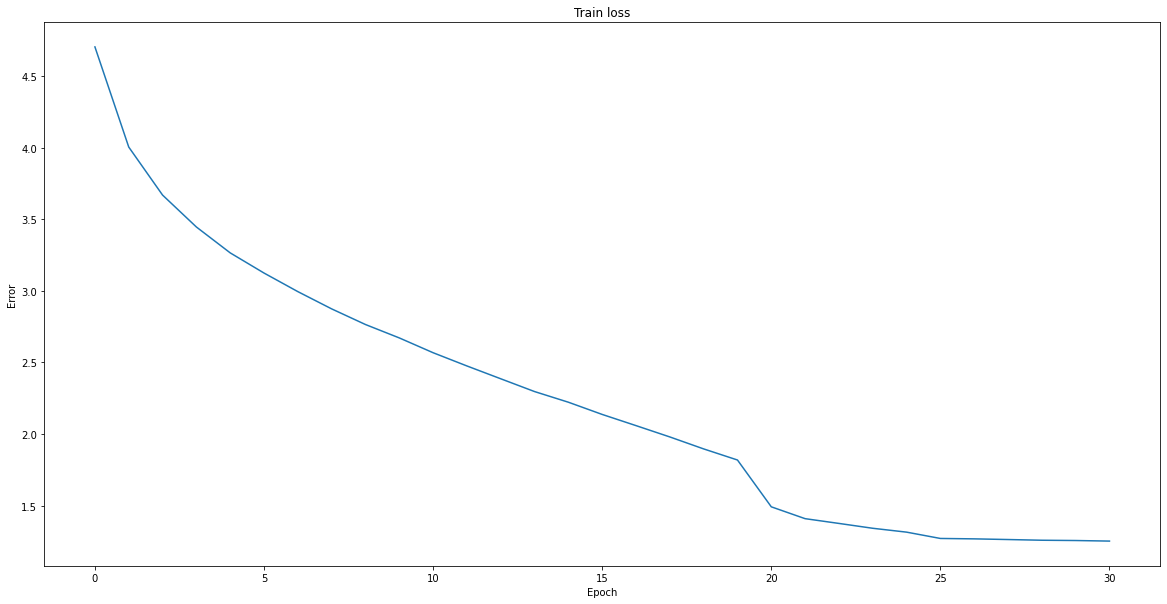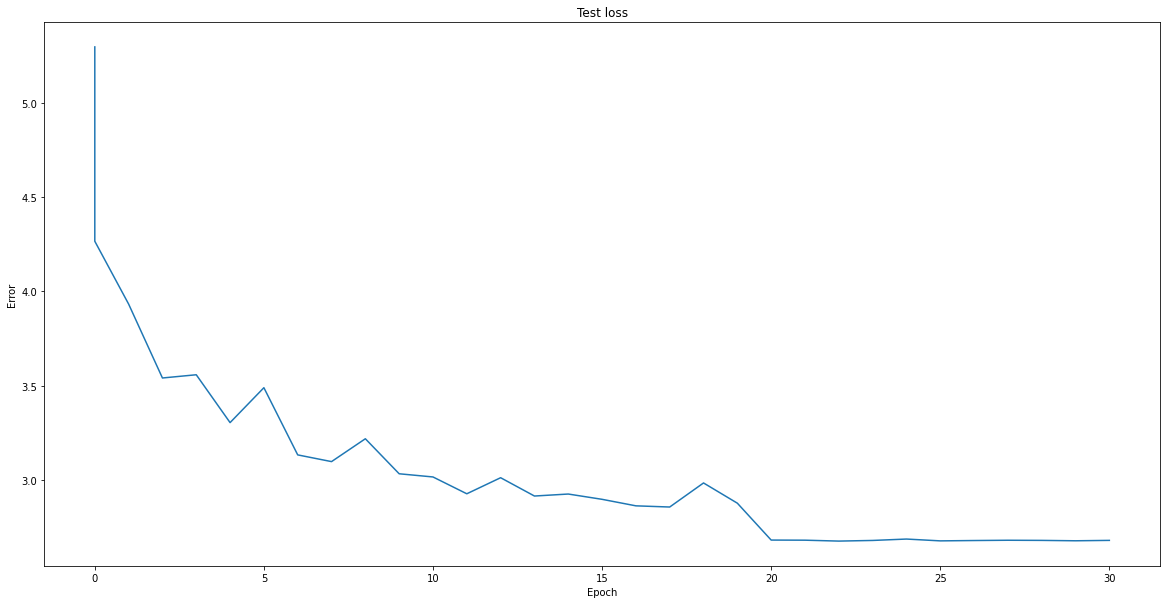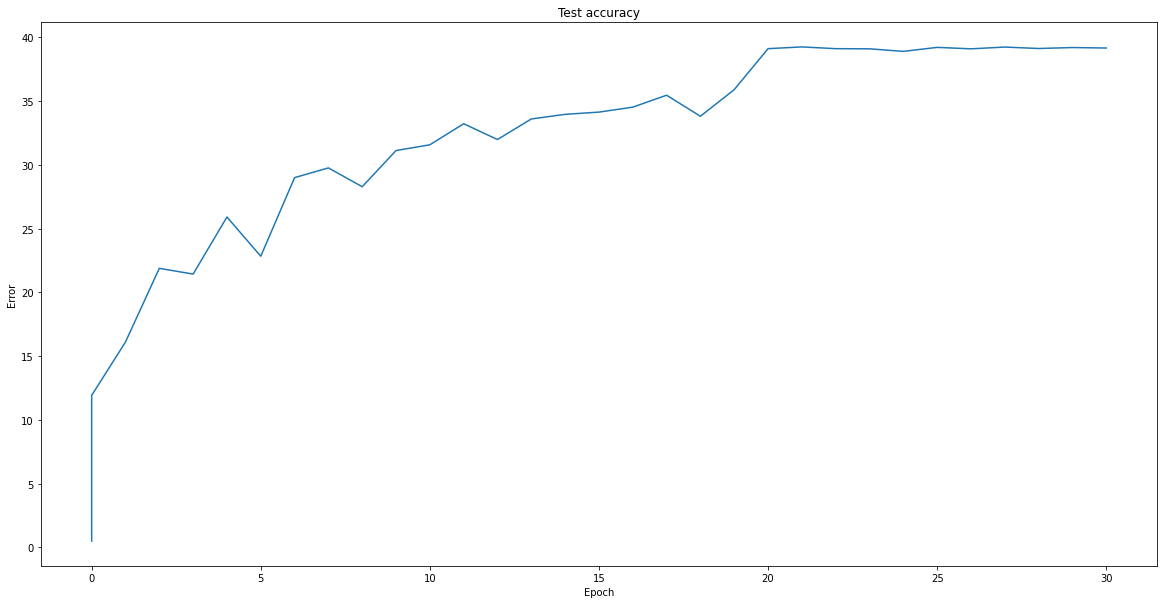

2. Were you able to use larger/deeper networks on TinyImageNet than you used on CIFAR and increase accuracy? If so, why? If not, why not?

Yes. It looks like for a more difficult task like TinyImageNet, overfitting is much less possible than a simple task like CIFAR. In CIFAR, a deeper network only makes the convergence slower as most of the regularizations (batch normalization, residual connection) are not necessary to achieve a satisfactory accuracy. On the other hand, these techniques are needed to avoid a bunch of problems such as gradient vanishing in a large model (which is needed to process image of greater size and more class classification)

3. The real ImageNet dataset has significantly larger images. How would you change your network design if the images were twice as large? How about smaller than Tiny ImageNet? How do you think your accuracy would change? This is open-ended, but we want a more thought-out answer than "I'd resize the images" or "I'd do a larger pooling stride." You don't have to write code to test your hypothesis.

If the image is twice as large, the model will still work as the final average pooling layer will ensure that the image is compressed to only one scalar value. I might try to add a layer of convolution downsampling from 512 to 1024 (similar to what I did from 256 to 1024) and two layers of residual convolution to ensure that the model is powerful enough to handle larger image. The accuracy will decrease as it will be harder to extract features from a large image.

if the image is smaller, I will need to make sure it is at least as large as 32 * 32 to ensure that the model will work. If it is even smaller, I will reduce the number of layers to perhaps only 256 (or even lower) instead of 512 so that the downsampling using convolution or maxpooling still makes sense. The accuracy is likely to increase since there will be less pixel to process. But if the image is much much smaller, than it might be really hard to classify into 200 classes based on a really small image, hence the accuracy will suffer.

# Turn-in

Download your `hw1.ipynb` and put it in your `uwnet` repository.